In [7]:
from importlib import reload  # Python 3.4+

import sys
sys.path.append("..")
import helper.helper as h
import helper.methods as m
import pickle
import numpy as np
import matplotlib.pyplot as plt

import notears.notears.notears.utils as utils
import notears.notears.notears.linear as linear

from tqdm import tqdm
from timeit import default_timer as timer
import itertools
import math

### Generating Data
Parameters:
- $p$, number of variables.
- $s$, number of arcs.
- $|s|$, size of autoregressive coefficients.
- $T$, number of timesteps.

In [21]:
n, p, s = 100, 5, 10

utils.set_random_seed(seed = 1)
W = utils.simulate_parameter(utils.simulate_dag(p, s, "ER"), w_ranges=((-2.0, -0.5), (0.5, 2.0)))
X = utils.simulate_linear_sem(W, n, "gauss")

[[ 0.         -1.87666118  1.02747896  1.63197154 -0.71325507]
 [ 0.          0.         -1.16274976 -1.15102099 -1.42665047]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.          0.         -0.63568902  0.          0.        ]
 [ 0.          0.          0.55892265 -1.32137923  0.        ]]
[[ 0.         -1.87421111 -0.19684772  1.68430011 -0.79172154]
 [ 0.          0.         -0.43792775 -1.36547378 -1.4286161 ]
 [ 0.          0.          0.         -0.44712946  0.        ]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          1.49852721 -0.66200637  0.        ]]


(0.9, 0.9333333333333333, 0.1, 0.9, 2, 4.880071878754125, 0.8848266549899652)

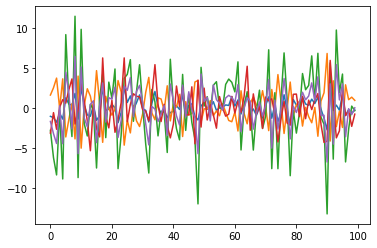

In [101]:
def gen_sem(p, s, n, low = 0.5, high = 2.0, seed = 12345):
    utils.set_random_seed(seed = seed)
    W = utils.simulate_parameter(utils.simulate_dag(p, min(s, int(p * (p - 1) / 2)), "ER"), w_ranges=((-low, -high), (low, high)))
    X = utils.simulate_linear_sem(W, n, "gauss")
    return W, X

n, p, s = 100, 5, 15
W, X = gen_sem(p = p, s = s, n = n, seed = 10)
print(W)
plt.plot(X);

### Generate the datasets

In [122]:
from tqdm import tqdm
datasets = []

p_range = [5, 10, 15, 25]

for p in tqdm(p_range):
    datasets_p = []
    for i in range(10):
        W, X = gen_sem(p, 3 * p, 1000, seed = 10 + i)
        datasets_p.append((W, X))
        # plt.plot(X)
        # plt.show()
    datasets.append(datasets_p)

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 25.81it/s]


In [103]:
def con_OLS(X, B):
    p = np.shape(B)[0]
    W = np.zeros((p, p))
    for i in range(p):
        X_F = X[:, B[:, i]]
        W[B[:, i], i] = np.linalg.inv(X_F.T @ X_F) @ X_F.T @ X[:, i]
        
    return W

In [104]:
def expected_MSE_X(W): return np.linalg.inv(np.identity(p) - W).T @ np.linalg.inv(np.identity(p) - W)

def expected_cost_sem(W_true, W_est):
    """Expected Cost of a Structural Equation Model with X = X W_est, when truth is X = X W_true"""
    
    # base on the distribution of X, no actual data needed.    
    covariance_matrix = (W_est - np.identity(p)).T @ expected_MSE_X(W_true) @ (W_est - np.identity(p))
    
    # return expected MSE
    return np.trace(covariance_matrix)

In [105]:
def evaluate(results, X, W_true, W_m, method, epsilon = 0.30, verbose = True):
    # get mse
    _, _, _, _, shd_1, mse, _ = h.score(X, W_m, W_true, is_sem = True, printing = False)
    results[method]['mse'].append(mse)
    
    # do thresholding to get shd
    W_m[np.abs(W_m) <= epsilon] = 0

    _, _, _, _, shd, _, _ = h.score(X, W_m, W_true, is_sem = True, printing = False)
    results[method]['shd'].append(shd)
    
    # do reestimated to get expected mean squared error
    emse = expected_cost_sem(W_true, con_OLS(X, W_m != 0))
    results[method]['emse'].append(emse)
    
    if verbose:
        print(method)
        print(f"SHD: {shd}, Empirial Risk: {round(mse, 3)}, True Risk: {round(emse, 3)}.")
        
    return results

In [120]:
# mean squared, true risk, and shd per method
results = {
#     "exh": {"mse": [], "emse": [], "shd": []},
#     "rw_1": {"mse": [], "emse": [], "shd": []},
    "rw_2": {"mse": [], "emse": [], "shd": []},
    "mcmc_r": {"mse": [], "emse": [], "shd": []},
#     "mcmc_t": {"mse": [], "emse": [], "shd": []},
#     "mcmc_s": {"mse": [], "emse": [], "shd": []},
    "mcmc_g": {"mse": [], "emse": [], "shd": []},
    "notears": {"mse": [], "emse": [], "shd": []},
#     "daglasso": {"mse": [], "emse": [], "shd": []},
    "dagomp": {"mse": [], "emse": [], "shd": []},
    "dagols": {"mse": [], "emse": [], "shd": []},
}


In [ ]:
import time
iters = 1000

old_time = time.time()
# for each dataset
for dataset in datasets:
    for W, X in dataset:
        print(W)
        # for each method:
        T, p = np.shape(X)
        m.T, m.p = T, p
    
    # covariance_X = np.matmul(np.linalg.inv(np.identity(p ** 2) - np.kron(W.T, W.T)), np.identity(p).reshape(p ** 2)).reshape((p, p))
    
    # 1: Exhaustive:
#     if p <= 8:
#         W_exh = m.exh(X[:-1], X[1:])
        
#         # 2.1: Random Walk 1, need regularizing
#         W_rw_1 = m.rw_1(X[:-1], X[1:], np.identity(p), iters)[1]
#         results = evaluate(results, X, W, W_rw_1, "rw_1")
    
    # 2.2: Random Walk 2
        W_rw_2 = m.rw_2(X, X, np.identity(p), iters, is_sem = True)[1]
        results = evaluate(results, X, W, W_rw_2, "rw_2")
    
    # 3.1: MCMC 1
        W_mcmc_1 = m.mcmc_1(X, X, iters, np.identity(p), is_sem = True)[1]
        results = evaluate(results, X, W, W_mcmc_1, "mcmc_r")
    
# #     # 3.2: MCMC 2
# #     W_mcmc_2 = m.mcmc_2(X[:-1], X[1:], iters, np.identity(p))[1]
# #     results = evaluate(results, X, W, W_mcmc_2, "mcmc_t")
    
# #     # 3.3: MCMC 3
# #     W_mcmc_3 = m.mcmc_3(X[:-1], X[1:], iters, np.identity(p))[1]
# #     results = evaluate(results, X, W, W_mcmc_3, "mcmc_s")
    
    # 3.4: MCMC 4
        W_mcmc_4 = m.mcmc_4(X, X, iters, np.identity(p), is_sem = True)[1]
        results = evaluate(results, X, W, W_mcmc_4, "mcmc_g")
    
    # 4: NO TEARS, NEED TO REGULARIZE using bootstrap.
        W_notears, _ = linear.notears_linear(X, lambda1 = 0.0, loss_type = "l2")
        results = evaluate(results, X, W, W_notears, "notears")
    
        # 5: LASSO-DAG, NEED TO REGULARIZE using bootstrap.
#         W_lassodag, alpha = m._LASSO_LINGNAM(X, step_size = 0.1)
#         print("DAG-LASSO alpha:", alpha)
#         results = evaluate(results, X, W, W_lassodag, "daglasso")
    
    # 6: DAG-OMP, NEED TO REGULARIZE using cross-validation.
        W_omp, _ = m._K_OMP(X, X, F = [], normalize = True, is_sem = True)
        results = evaluate(results, X, W, W_omp, "dagomp")

        # 7: DAG-LASSO, NEED TO REGULARIZE using bootstrap.
        W_ols_dag = con_OLS(X, B_V_LINGNAM_OLS(X) != 0)
        results = evaluate(results, X, W, W_ols_dag, "dagols")
        
print(f"Done! Took {time.time() - old_time} seconds.")

  9%|███████                                                                        | 89/1000 [00:00<00:01, 890.00it/s]

[[ 0.         -1.87666118  1.02747896  1.63197154 -0.71325507]
 [ 0.          0.         -1.16274976 -1.15102099 -1.42665047]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.          0.         -0.63568902  0.          0.        ]
 [ 0.          0.          0.55892265 -1.32137923  0.        ]]


  9%|███████                                                                        | 90/1000 [00:00<00:01, 899.99it/s]

rw_2
SHD: 0, Empirial Risk: 4.902, True Risk: 5.015.


  9%|███████▎                                                                       | 92/1000 [00:00<00:00, 919.96it/s]

mcmc_r
SHD: 0, Empirial Risk: 4.902, True Risk: 5.015.


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 730.45it/s]


mcmc_g
SHD: 0, Empirial Risk: 4.902, True Risk: 5.015.


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

h: 1.233460444893808e-09.
rho: 100000000000.0.
loss: (2.4971500041475188, array([ 1.82138775e-02,  3.74118755e-05,  1.03018967e-03,  2.23235386e-04,
        4.88371793e-03, -4.00700967e-02,  1.77805971e-02,  1.94742290e-03,
        9.97983349e-04,  1.03726692e-03,  6.02999377e-02, -4.24093503e-02,
        2.57747709e-02,  2.80568868e-05,  2.55780175e-02,  2.66532065e-02,
        9.60192347e-03, -1.09940568e-02,  1.37908181e-02, -2.41584692e-02,
        2.93029637e-02, -2.48162586e-02, -5.39084985e-03,  1.09970688e-04,
        1.84377416e-02, -1.82138775e-02, -3.74118755e-05, -1.03018967e-03,
       -2.23235386e-04, -4.88371793e-03,  4.00700967e-02, -1.77805971e-02,
       -1.94742290e-03, -9.97983349e-04, -1.03726692e-03, -6.02999377e-02,
        4.24093503e-02, -2.57747709e-02, -2.80568868e-05, -2.55780175e-02,
       -2.66532065e-02, -9.60192347e-03,  1.09940568e-02, -1.37908181e-02,
        2.41584692e-02, -2.93029637e-02,  2.48162586e-02,  5.39084985e-03,
       -1.09970688e-04, -1

  9%|███████▎                                                                       | 93/1000 [00:00<00:00, 920.81it/s]

rw_2
SHD: 0, Empirial Risk: 5.032, True Risk: 5.025.


  9%|███████                                                                        | 89/1000 [00:00<00:01, 881.18it/s]

mcmc_r
SHD: 0, Empirial Risk: 5.032, True Risk: 5.025.


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 878.73it/s]


mcmc_g
SHD: 0, Empirial Risk: 5.032, True Risk: 5.025.
h: 1.1471108507521421e-09.
rho: 100000000000.0.
loss: (2.5136190048760585, array([ 2.11999218e-02, -2.00606299e-02,  2.32597454e-03, -1.14815755e-02,
       -2.98345367e-02, -1.02270829e-03,  2.17849264e-02, -7.66955306e-04,
       -1.07657063e-03, -2.28397236e-03, -3.16090297e-02,  4.82800905e-03,
        1.47929959e-02,  5.63151943e-02,  6.28653738e-02,  2.38140057e-06,
       -3.28357210e-02, -4.40739847e-05,  2.02974939e-02, -2.07186406e-03,
        1.80012565e-03, -2.19423807e-02, -3.68437024e-04,  2.11654295e-02,
        1.96731294e-02, -2.11999218e-02,  2.00606299e-02, -2.32597454e-03,
        1.14815755e-02,  2.98345367e-02,  1.02270829e-03, -2.17849264e-02,
        7.66955306e-04,  1.07657063e-03,  2.28397236e-03,  3.16090297e-02,
       -4.82800905e-03, -1.47929959e-02, -5.63151943e-02, -6.28653738e-02,
       -2.38140057e-06,  3.28357210e-02,  4.40739847e-05, -2.02974939e-02,
        2.07186406e-03, -1.80012565e-03,  2.1

  9%|██████▊                                                                        | 86/1000 [00:00<00:01, 851.47it/s]

rw_2
SHD: 0, Empirial Risk: 4.802, True Risk: 5.008.


  8%|██████▍                                                                        | 82/1000 [00:00<00:01, 820.00it/s]

mcmc_r
SHD: 0, Empirial Risk: 4.802, True Risk: 5.008.


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 862.06it/s]


mcmc_g
SHD: 0, Empirial Risk: 4.802, True Risk: 5.008.
h: 1.1733920501910688e-09.
rho: 100000000000.0.
loss: (2.4747563218420066, array([ 0.01483813,  0.01809794, -0.02664062, -0.002972  ,  0.00468876,
        0.00074169,  0.01660264,  0.00107584,  0.00068632, -0.00088066,
        0.00221054,  0.01534459,  0.01594964, -0.00011322, -0.00366811,
        0.02878183, -0.01092062, -0.06094914,  0.01159463, -0.01364336,
       -0.01458563,  0.01575692,  0.06057012,  0.00462165,  0.02414921,
       -0.01483813, -0.01809794,  0.02664062,  0.002972  , -0.00468876,
       -0.00074169, -0.01660264, -0.00107584, -0.00068632,  0.00088066,
       -0.00221054, -0.01534459, -0.01594964,  0.00011322,  0.00366811,
       -0.02878183,  0.01092062,  0.06094914, -0.01159463,  0.01364336,
        0.01458563, -0.01575692, -0.06057012, -0.00462165, -0.02414921])).
notears
SHD: 4, Empirial Risk: 4.952, True Risk: 5.156.
dagomp
SHD: 6, Empirial Risk: 6.258, True Risk: 6.659.
dagols

  9%|███████▎                                                                       | 92/1000 [00:00<00:00, 919.95it/s]


SHD: 2, Empirial Risk: 7.028, True Risk: 7.281.
[[ 0.          0.86671355  0.         -1.92364127 -0.82684851]
 [ 0.          0.          0.          1.52912762  1.32239015]
 [-1.81072016  0.64812983  0.         -1.71926176 -0.61357617]
 [ 0.          0.          0.          0.          0.60910582]
 [ 0.          0.          0.          0.          0.        ]]


  9%|███████                                                                        | 90/1000 [00:00<00:01, 891.13it/s]

rw_2
SHD: 0, Empirial Risk: 5.018, True Risk: 5.007.


  9%|███████▎                                                                       | 92/1000 [00:00<00:00, 910.88it/s]

mcmc_r
SHD: 0, Empirial Risk: 5.018, True Risk: 5.007.


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 843.16it/s]


mcmc_g
SHD: 0, Empirial Risk: 5.018, True Risk: 5.007.
h: 1.0604210842757311e-09.
rho: 100000000000.0.
loss: (2.5055942978939734, array([ 1.82099880e-02, -1.04394713e-03, -2.95732192e-02,  1.30453276e-03,
        7.25274253e-04,  2.10740715e-02,  2.04003962e-02, -1.77277172e-02,
       -1.15726499e-03, -6.27355079e-04, -1.68641990e-04, -3.29324292e-05,
        1.67696005e-02,  2.12678506e-03,  2.22330504e-04, -9.89203367e-03,
        3.70196614e-02,  3.08702637e-03,  1.85192346e-02, -1.44727016e-03,
        1.72743395e-03,  4.24746851e-02, -3.09627475e-02,  1.26282204e-02,
        1.69311791e-02, -1.82099880e-02,  1.04394713e-03,  2.95732192e-02,
       -1.30453276e-03, -7.25274253e-04, -2.10740715e-02, -2.04003962e-02,
        1.77277172e-02,  1.15726499e-03,  6.27355079e-04,  1.68641990e-04,
        3.29324292e-05, -1.67696005e-02, -2.12678506e-03, -2.22330504e-04,
        9.89203367e-03, -3.70196614e-02, -3.08702637e-03, -1.85192346e-02,
        1.44727016e-03, -1.72743395e-03, -4.2

  8%|██████▎                                                                        | 80/1000 [00:00<00:01, 799.98it/s]


SHD: 0, Empirial Risk: 5.018, True Risk: 5.007.
[[ 0.          0.          0.          0.          0.93185728]
 [-0.95013797  0.          1.91551843 -0.88638865  0.81863206]
 [-1.48550009  0.          0.          0.86996875 -0.62502374]
 [-1.61984618  0.          0.          0.          1.43160534]
 [ 0.          0.          0.          0.          0.        ]]


  8%|██████▌                                                                        | 83/1000 [00:00<00:01, 821.83it/s]

rw_2
SHD: 0, Empirial Risk: 4.944, True Risk: 5.005.


  7%|█████▌                                                                         | 70/1000 [00:00<00:01, 699.98it/s]

mcmc_r
SHD: 0, Empirial Risk: 4.944, True Risk: 5.005.


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 769.22it/s]


mcmc_g
SHD: 0, Empirial Risk: 4.944, True Risk: 5.005.
h: 1.262376869703985e-09.
rho: 100000000000.0.
loss: (2.4684123138242393, array([ 0.01907904, -0.10206936, -0.05903027, -0.02969951, -0.00781695,
        0.00013602,  0.02095225, -0.00091529, -0.00067557, -0.00157096,
        0.00261748,  0.03792908,  0.02009937, -0.00872504,  0.00249684,
        0.00111638,  0.01434176,  0.01706086,  0.01947294, -0.00029526,
        0.01384126, -0.08210483, -0.04036459, -0.00116639,  0.0178276 ,
       -0.01907904,  0.10206936,  0.05903027,  0.02969951,  0.00781695,
       -0.00013602, -0.02095225,  0.00091529,  0.00067557,  0.00157096,
       -0.00261748, -0.03792908, -0.02009937,  0.00872504, -0.00249684,
       -0.00111638, -0.01434176, -0.01706086, -0.01947294,  0.00029526,
       -0.01384126,  0.08210483,  0.04036459,  0.00116639, -0.0178276 ])).
notears
SHD: 0, Empirial Risk: 4.944, True Risk: 5.005.
dagomp
SHD: 7, Empirial Risk: 6.979, True Risk: 7.235.


  6%|████▉                                                                          | 63/1000 [00:00<00:01, 629.98it/s]

dagols
SHD: 1, Empirial Risk: 5.687, True Risk: 5.762.
[[ 0.          1.22529366  1.59389005  1.6737375   0.88657382]
 [ 0.          0.         -0.84202605 -1.21648309  0.        ]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.          0.         -1.74000948  0.          0.        ]
 [ 0.          0.92145903 -1.49606097 -1.59956042  0.        ]]


  8%|██████                                                                         | 77/1000 [00:00<00:01, 762.40it/s]

rw_2
SHD: 0, Empirial Risk: 5.098, True Risk: 5.006.


  8%|██████▍                                                                        | 82/1000 [00:00<00:01, 819.99it/s]

mcmc_r
SHD: 0, Empirial Risk: 5.098, True Risk: 5.006.


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 868.80it/s]


mcmc_g
SHD: 0, Empirial Risk: 5.098, True Risk: 5.006.
h: 1.1661658305683886e-09.
rho: 100000000000.0.
loss: (2.547686941467611, array([ 0.01976187,  0.00095979, -0.00057673, -0.00019295, -0.00454604,
        0.03728477,  0.02018252,  0.00127504,  0.00439719,  0.01177083,
        0.04979563,  0.02613243,  0.02023441, -0.03485898,  0.04954604,
       -0.04071284, -0.02701214,  0.00350657,  0.02039155, -0.05186944,
        0.01884091,  0.0009845 ,  0.00038635,  0.00401259,  0.0195535 ,
       -0.01976187, -0.00095979,  0.00057673,  0.00019295,  0.00454604,
       -0.03728477, -0.02018252, -0.00127504, -0.00439719, -0.01177083,
       -0.04979563, -0.02613243, -0.02023441,  0.03485898, -0.04954604,
        0.04071284,  0.02701214, -0.00350657, -0.02039155,  0.05186944,
       -0.01884091, -0.0009845 , -0.00038635, -0.00401259, -0.0195535 ])).
notears
SHD: 0, Empirial Risk: 5.098, True Risk: 5.006.
dagomp
SHD: 3, Empirial Risk: 5.95, True Risk: 5.908.
dagols

 10%|███████▌                                                                       | 96/1000 [00:00<00:00, 950.53it/s]


SHD: 2, Empirial Risk: 6.707, True Risk: 6.638.
[[ 0.          0.          0.73959384  0.         -1.09255296]
 [-0.79192311  0.         -0.69649418 -1.73184791 -0.58866802]
 [ 0.          0.          0.          0.          0.        ]
 [-1.12976828  0.         -1.50332647  0.          1.64843503]
 [ 0.          0.         -0.67654237  0.          0.        ]]


  8%|██████                                                                         | 77/1000 [00:00<00:01, 769.96it/s]

rw_2
SHD: 0, Empirial Risk: 4.9, True Risk: 5.004.


  9%|███████▎                                                                       | 92/1000 [00:00<00:00, 919.96it/s]

mcmc_r
SHD: 0, Empirial Risk: 4.9, True Risk: 5.004.


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 887.30it/s]


mcmc_g
SHD: 0, Empirial Risk: 4.9, True Risk: 5.004.
h: 1.410619177022454e-09.
rho: 100000000000.0.
loss: (2.4461032926576363, array([ 1.95768128e-02,  2.15115086e-02,  8.99902828e-05, -2.07823396e-02,
        1.62080433e-03,  1.05614231e-03,  1.96238488e-02,  1.74318365e-03,
        7.56442748e-04,  6.73179389e-05,  2.63556193e-02,  1.08497218e-01,
        2.01724931e-02, -8.31381693e-02, -1.28556308e-02,  6.50295829e-03,
       -3.32991458e-02,  2.06268099e-03,  2.01850877e-02, -2.49766869e-03,
       -1.82456100e-02, -8.66874538e-02, -2.20530749e-03,  5.60939622e-02,
        1.93996173e-02, -1.95768128e-02, -2.15115086e-02, -8.99902828e-05,
        2.07823396e-02, -1.62080433e-03, -1.05614231e-03, -1.96238488e-02,
       -1.74318365e-03, -7.56442748e-04, -6.73179389e-05, -2.63556193e-02,
       -1.08497218e-01, -2.01724931e-02,  8.31381693e-02,  1.28556308e-02,
       -6.50295829e-03,  3.32991458e-02, -2.06268099e-03, -2.01850877e-02,
        2.49766869e-03,  1.82456100e-02,  8.6687

  8%|██████▏                                                                        | 79/1000 [00:00<00:01, 782.18it/s]


SHD: 0, Empirial Risk: 4.9, True Risk: 5.004.
[[ 0.          0.          1.57816412 -0.94658858 -1.34226336]
 [ 0.7009185   0.         -1.12772658  1.74395715  0.54373549]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.          0.         -1.31749786  0.          0.        ]
 [ 0.          0.          1.82579633 -1.69590159  0.        ]]


  6%|████▉                                                                          | 63/1000 [00:00<00:01, 623.77it/s]

rw_2
SHD: 0, Empirial Risk: 5.211, True Risk: 5.006.


  9%|██████▊                                                                        | 86/1000 [00:00<00:01, 851.51it/s]

mcmc_r
SHD: 0, Empirial Risk: 5.211, True Risk: 5.006.


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 833.33it/s]


mcmc_g
SHD: 0, Empirial Risk: 5.211, True Risk: 5.006.
h: 1.2482246347644832e-09.
rho: 100000000000.0.
loss: (2.6779549916033742, array([ 0.03307801, -0.00304654, -0.00066729,  0.00393831,  0.0046992 ,
        0.01521652,  0.0151728 ,  0.00078412, -0.00071567, -0.00083421,
       -0.10193366, -0.01636638,  0.02264903, -0.02588445,  0.06668892,
        0.05150193,  0.0112441 ,  0.00408631,  0.02107919, -0.02831846,
       -0.03223969,  0.00975804, -0.00350253, -0.00137508,  0.01955855,
       -0.03307801,  0.00304654,  0.00066729, -0.00393831, -0.0046992 ,
       -0.01521652, -0.0151728 , -0.00078412,  0.00071567,  0.00083421,
        0.10193366,  0.01636638, -0.02264903,  0.02588445, -0.06668892,
       -0.05150193, -0.0112441 , -0.00408631, -0.02107919,  0.02831846,
        0.03223969, -0.00975804,  0.00350253,  0.00137508, -0.01955855])).
notears
SHD: 2, Empirial Risk: 5.373, True Risk: 5.168.
dagomp
SHD: 0, Empirial Risk: 5.211, True Risk: 5.006.
dagols

  9%|███████▎                                                                       | 92/1000 [00:00<00:00, 919.95it/s]


SHD: 2, Empirial Risk: 9.75, True Risk: 9.652.
[[ 0.          0.          0.          0.          1.99607792]
 [ 0.83840096  0.         -0.79613193 -1.92418294 -1.21490058]
 [-1.49990052  0.          0.          0.51652504  1.67735413]
 [-0.95287727  0.          0.          0.          1.66568668]
 [ 0.          0.          0.          0.          0.        ]]


  8%|██████▋                                                                        | 84/1000 [00:00<00:01, 839.98it/s]

rw_2
SHD: 0, Empirial Risk: 5.109, True Risk: 5.014.


  9%|███████▎                                                                       | 93/1000 [00:00<00:00, 929.96it/s]

mcmc_r
SHD: 0, Empirial Risk: 5.109, True Risk: 5.014.


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 847.45it/s]


mcmc_g
SHD: 0, Empirial Risk: 5.109, True Risk: 5.014.
h: 1.2935092996713138e-09.
rho: 100000000000.0.
loss: (2.57740692582459, array([ 8.38264845e-03,  7.31063119e-02, -2.55865151e-02, -5.77166089e-02,
       -1.71463314e-03,  2.16086408e-04,  1.47975289e-02, -2.57013704e-03,
        1.62533678e-03,  4.73989579e-04,  3.84702833e-04, -1.92726451e-02,
        9.15073984e-03,  9.05782980e-03, -9.36726841e-04,  1.81302101e-03,
       -5.70064374e-02, -6.33795446e-03,  1.48076396e-02, -4.57138824e-05,
        4.69162798e-02,  4.74807508e-02,  5.24495826e-03, -1.40412127e-02,
        7.32186476e-03, -8.38264845e-03, -7.31063119e-02,  2.55865151e-02,
        5.77166089e-02,  1.71463314e-03, -2.16086408e-04, -1.47975289e-02,
        2.57013704e-03, -1.62533678e-03, -4.73989579e-04, -3.84702833e-04,
        1.92726451e-02, -9.15073984e-03, -9.05782980e-03,  9.36726841e-04,
       -1.81302101e-03,  5.70064374e-02,  6.33795446e-03, -1.48076396e-02,
        4.57138824e-05, -4.69162798e-02, -4.748

  6%|████▋                                                                          | 59/1000 [00:00<00:01, 590.00it/s]

dagols
SHD: 1, Empirial Risk: 7.702, True Risk: 7.282.
[[ 0.          0.7696082   0.         -1.66603688 -1.41205145]
 [ 0.          0.          0.          0.          0.        ]
 [ 1.90445436  1.50916107  0.          1.2863416   1.17338264]
 [ 0.          1.78865674  0.          0.          0.        ]
 [ 0.          1.75155725  0.          1.04218887  0.        ]]


  8%|██████▍                                                                        | 81/1000 [00:00<00:01, 809.99it/s]

rw_2
SHD: 0, Empirial Risk: 5.185, True Risk: 5.015.


  8%|██████▋                                                                        | 84/1000 [00:00<00:01, 831.74it/s]

mcmc_r
SHD: 0, Empirial Risk: 5.185, True Risk: 5.015.


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 856.16it/s]


mcmc_g
SHD: 0, Empirial Risk: 5.185, True Risk: 5.015.
h: 1.3616316962838937e-09.
rho: 100000000000.0.
loss: (2.5911223596592494, array([ 0.022606  ,  0.00292143,  0.03693194,  0.00520782,  0.00762855,
       -0.16403687,  0.01983195, -0.13027684,  0.03136168,  0.07318455,
       -0.0006014 ,  0.00183915,  0.02186131, -0.00029788, -0.00074426,
       -0.06463362, -0.00910518, -0.06904322,  0.01918891,  0.01339486,
       -0.03735272, -0.00403183, -0.02965374, -0.00350028,  0.02189584,
       -0.022606  , -0.00292143, -0.03693194, -0.00520782, -0.00762855,
        0.16403687, -0.01983195,  0.13027684, -0.03136168, -0.07318455,
        0.0006014 , -0.00183915, -0.02186131,  0.00029788,  0.00074426,
        0.06463362,  0.00910518,  0.06904322, -0.01918891, -0.01339486,
        0.03735272,  0.00403183,  0.02965374,  0.00350028, -0.02189584])).
notears
SHD: 0, Empirial Risk: 5.186, True Risk: 5.015.
dagomp
SHD: 0, Empirial Risk: 5.185, True Risk: 5.015.
dagols

  6%|████▉                                                                          | 62/1000 [00:00<00:03, 310.48it/s]


SHD: 2, Empirial Risk: 7.847, True Risk: 7.282.
[[ 0.          0.         -1.30183692  0.          0.          1.33594311
  -0.61941964  0.          0.         -1.66074544]
 [ 0.          0.         -0.97239031  0.         -1.01952073  0.53174779
   1.62569692 -1.64486088  1.18777131  1.26968406]
 [ 0.          0.          0.         -0.89332349  1.77314611 -0.53809967
  -0.95459384 -0.86311381  0.          1.0080187 ]
 [ 0.          0.          0.          0.          0.          0.94074733
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          1.79671879  0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.         -1.61690486  0.         -1.39738351
   0.         -0.77605223  0.          0.        ]
 [ 0.          0.          0.         -1.0721173   0.         -1.88803531
   0.          0. 

  3%|██▋                                                                            | 34/1000 [00:00<00:02, 339.99it/s]

rw_2
SHD: 20, Empirial Risk: 14.504, True Risk: 17.163.


  4%|██▉                                                                            | 37/1000 [00:00<00:02, 362.74it/s]

mcmc_r
SHD: 13, Empirial Risk: 13.109, True Risk: 13.176.


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 337.95it/s]


mcmc_g
SHD: 0, Empirial Risk: 9.771, True Risk: 10.022.
h: 1.3570211621072303e-09.
rho: 100000000000000.0.
loss: (5.137006402446862, array([ 6.13949790e+00,  2.34911765e-03,  1.05538456e-02, -2.35620542e-04,
       -3.91438238e-04, -8.20952640e-05,  2.00913456e-03,  2.61619725e-04,
        2.94255771e-03,  3.69846539e-03,  2.90941147e-01,  3.29286500e+00,
       -6.50180337e+00,  3.06851601e-04, -3.22363450e-04,  5.35753431e-04,
       -1.70899819e-03, -7.29036611e-04, -5.09320934e-03, -2.37266924e-03,
       -8.50321050e+00,  9.19125638e-05,  1.36529946e+01,  1.18848152e-03,
       -2.01126943e-03, -4.92808996e-04,  5.65316034e-04,  3.23228222e-03,
       -3.73827175e-03, -3.57536030e-03, -1.44823452e+02,  2.68673879e+01,
        9.04294821e+01,  6.57035702e+00,  1.28623470e+01, -1.56417735e-02,
       -4.67533017e+00, -7.23712965e+00,  9.12339521e+00,  4.32712752e+01,
       -4.77749909e+01,  3.84295448e+00,  4.13202152e+01, -1.96215548e-03,
        6.67236647e+00, -5.36437601e-03, -

  4%|███▎                                                                           | 42/1000 [00:00<00:02, 415.83it/s]

dagols
SHD: 16, Empirial Risk: 49.467, True Risk: 51.288.
[[ 0.          0.87169946  0.58117296  1.96953996  0.          0.
   1.21738496 -1.93616608 -1.00081163  0.57976974]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.78608242  0.          0.
   0.          0.          0.75618522  0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          1.35245875 -1.15733101  0.          0.          0.
  -1.01556996  0.          0.          0.        ]
 [ 0.          0.          0.         -1.73847834 -1.30054097  0.
   1.43524491  0.          1.86267191  0.        ]
 [ 0.          1.22354164  1.24033154  0.78164857  0.          0.
   0.          0.          1.12296127  0.        ]
 [ 0.          0.         -1.86769323 -0.97051873  0.          0.
   1.63833516  0.          1.90625628  0.        ]
 [ 0. 

  4%|██▉                                                                            | 37/1000 [00:00<00:02, 369.98it/s]

rw_2
SHD: 12, Empirial Risk: 11.161, True Risk: 11.568.


  4%|██▉                                                                            | 37/1000 [00:00<00:02, 366.33it/s]

mcmc_r
SHD: 21, Empirial Risk: 10.785, True Risk: 11.364.


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 365.63it/s]


mcmc_g
SHD: 0, Empirial Risk: 9.871, True Risk: 10.025.
h: 1.3961560796360573e-09.
rho: 100000000000000.0.
loss: (5.301997062281268, array([ 5.18206861e+00,  8.21254512e-03,  4.17607958e-04,  1.43067168e-04,
        1.26632709e-03,  1.51631682e-03, -1.69024393e-03,  1.49687792e-03,
       -2.79425792e-03,  3.86353291e+00,  1.70540371e+01,  6.11212739e+00,
       -8.10538366e-04,  1.25099653e-03,  6.78789294e+00, -3.75572867e+01,
       -2.06913385e+01, -8.92976714e+00, -8.11958829e+00,  6.34287928e+01,
        7.84145997e+00, -8.00346662e-01,  4.16590413e+00,  1.13144341e-04,
       -4.05054497e+00,  3.39165427e+01,  2.41508726e+01,  1.62244170e+00,
        4.87735600e+00, -2.51397628e+01,  1.85487442e+01, -7.85709094e-01,
        3.25697233e+00,  6.63909851e+00, -3.22641949e+00,  2.87524709e+01,
        2.93110457e+01,  3.43254827e+00,  4.09369532e+00, -1.36223480e+01,
        3.72005754e-01, -8.00605184e-03, -1.38191943e-04, -1.34385993e-03,
        3.39563542e+00, -8.88193979e+00, -

  4%|██▊                                                                            | 36/1000 [00:00<00:02, 352.94it/s]

dagols
SHD: 16, Empirial Risk: 46.18, True Risk: 46.444.
[[ 0.          0.          0.          0.          0.          0.
   0.64697936  0.          0.          0.        ]
 [ 0.83638613  0.          0.          0.          0.          0.
  -1.06098658 -1.3149719   0.         -0.69409374]
 [-0.52696394  0.          0.          0.          0.          0.
  -1.06917569 -0.69408844  0.          0.73350484]
 [ 1.96084955  0.          0.          0.          0.          0.
   0.          0.          0.         -1.87227493]
 [ 0.         -1.28840715  1.18761775  0.62764287  0.          1.11441152
   1.01563664  0.98533862  1.50290618  0.        ]
 [ 1.36732576  0.81904414  1.40508709  1.66335594  0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
  -1.41965588  0.          0.          0.        ]

  4%|███                                                                            | 38/1000 [00:00<00:02, 372.56it/s]

rw_2
SHD: 22, Empirial Risk: 12.883, True Risk: 13.279.


  4%|███                                                                            | 38/1000 [00:00<00:02, 379.99it/s]

mcmc_r
SHD: 13, Empirial Risk: 12.026, True Risk: 12.365.


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 360.88it/s]


mcmc_g
SHD: 0, Empirial Risk: 9.83, True Risk: 10.036.
h: 3.192187847389505e-09.
rho: 100000000000.0.
loss: (4.913365125988979, array([ 3.38582990e-02, -2.16662012e-03,  2.88329355e-02, -2.81885110e-02,
        1.92482979e-01,  2.29415587e-02, -6.36483155e-04,  1.33350949e-02,
        9.06084079e-02,  5.96066494e-02,  2.84154949e-03,  3.18105243e-02,
       -1.22772667e-03,  1.70975503e-03,  4.10551189e-02,  1.95767594e-02,
        9.68340524e-04, -3.72467497e-03,  3.69364323e-02, -3.04153587e-03,
        8.57007733e-04, -7.98096112e-03,  3.50758906e-02,  1.77741398e-02,
        1.64875656e-01,  3.72885750e-02,  9.13828491e-05, -7.94978513e-03,
        5.65857642e-02,  7.78125619e-04, -1.68902033e-03,  2.17993896e-02,
       -9.08570838e-03,  3.19324729e-02,  1.58534193e-02,  5.40955539e-02,
        5.06345073e-04, -3.22226196e-03, -4.02693098e-02, -4.52497820e-04,
       -1.11021167e-03, -3.79195814e-04, -3.58539294e-03, -1.25038720e-02,
        3.07909292e-02, -6.50742812e-03, -3.884

  4%|██▊                                                                            | 35/1000 [00:00<00:02, 343.16it/s]

dagols
SHD: 11, Empirial Risk: 16.081, True Risk: 16.132.
[[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          1.4204818 ]
 [ 1.90339908  0.80435734  0.          0.          0.         -1.0103912
   0.          1.18806996  0.         -1.50410921]
 [ 0.96250405  1.69341436  0.          0.          0.          0.
  -1.47519578  0.74917969  0.         -1.94464712]
 [ 0.          0.          0.          0.          0.         -0.73024196
   1.81861324 -0.60139834  0.71528082 -0.77011909]
 [-0.68639107 -0.83721091  0.          0.          0.          0.
   0.          0.          1.595626    1.93805102]
 [-1.31241594  1.60609985  0.          0.          0.          0.92203691
   0.          1.5286814  -1.34624042  0.74529962]
 [-0.71750444  1.23407234  0.          0.          0.          0.
   0.          0.          0.     

  2%|█▍                                                                             | 18/1000 [00:00<00:05, 168.23it/s]

rw_2
SHD: 8, Empirial Risk: 10.856, True Risk: 10.985.


  4%|██▊                                                                            | 35/1000 [00:00<00:02, 343.13it/s]

mcmc_r
SHD: 8, Empirial Risk: 10.549, True Risk: 10.582.


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 349.16it/s]


mcmc_g
SHD: 0, Empirial Risk: 9.971, True Risk: 10.02.
h: 4.9713904104464746e-09.
rho: 100000000000.0.
loss: (5.104356442007359, array([ 5.90493743e-02, -3.77391869e-04,  5.60939669e-02,  2.01950997e-01,
       -2.05439547e-01, -3.81962652e-02, -1.17771624e-01,  8.96169073e-04,
       -7.48774878e-03,  4.43999060e-05, -3.19280738e-02,  3.56153174e-02,
        1.37535104e-01, -5.92844656e-02,  2.07709610e-01, -2.84226296e-02,
        1.09352662e-01,  1.83675549e-02,  1.35113154e-02, -4.11770253e-04,
        9.37361232e-04, -6.41265758e-04,  3.79740252e-02,  2.63110415e-02,
       -4.85804112e-03,  2.98598275e-04, -1.63513331e-03,  8.27976784e-04,
       -9.98586585e-03,  1.07682691e-03,  8.05624045e-04, -4.25708187e-04,
        1.37924314e-03,  3.72295380e-02,  8.53098122e-04,  2.87757031e-04,
        8.67494006e-04, -9.18012800e-04,  5.18859088e-03,  2.99330897e-04,
       -1.79544792e-04,  3.51161434e-04,  4.54075903e-03,  7.99747176e-04,
        3.96356130e-02,  1.44219541e-03, -1.27

  3%|██▌                                                                            | 32/1000 [00:00<00:03, 316.83it/s]

dagols
SHD: 16, Empirial Risk: 25.118, True Risk: 24.696.
[[ 0.          0.         -1.39280483  0.          0.         -1.38456743
   0.          0.          0.          0.        ]
 [ 0.          0.         -0.81422235  0.          0.          0.
   0.          0.          0.         -1.71671746]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.         -1.86288724]
 [ 1.91654305 -1.30111077  0.          0.          1.13016765  0.
   0.          0.          0.          0.        ]
 [ 0.          1.27527475  0.          0.          0.          1.0311498
   0.          0.          0.          1.45223866]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [-1.18008919 -0.76635429  0.         -1.85088654 -1.64424285 -1.53198812
   0.          0.          0.          1.9696201 ]
 [ 0.66829328 -1.15417943  0.72259971  1.13328892  0.90802585 -1.37432998
   0.          0.         

  4%|██▊                                                                            | 35/1000 [00:00<00:02, 343.12it/s]

rw_2
SHD: 14, Empirial Risk: 12.493, True Risk: 12.878.


  3%|██▌                                                                            | 33/1000 [00:00<00:03, 320.40it/s]

mcmc_r
SHD: 11, Empirial Risk: 11.464, True Risk: 12.432.


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 334.11it/s]


mcmc_g
SHD: 0, Empirial Risk: 9.809, True Risk: 10.034.
h: 2.373401031263711e-09.
rho: 100000000000.0.
loss: (5.22420696855952, array([ 1.79957223e-02, -1.24718258e-02, -3.92724891e-04,  9.98772035e-02,
        7.54917685e-03,  1.61120163e-02, -8.73986744e-02,  5.50033624e-04,
        5.18089554e-02,  5.54192986e-05, -1.41370291e-03,  1.78873623e-02,
       -6.91201600e-04,  5.28495632e-03,  2.70422146e-02,  2.64120809e-03,
       -6.63558837e-02,  1.13773039e-03,  2.64828728e-03,  7.23313035e-04,
       -2.60890229e-02, -1.45003106e-02,  1.73012301e-02, -1.29072038e-01,
       -2.06384720e-02, -8.56856327e-03,  1.76897662e-01, -1.49936779e-02,
       -9.98355694e-02,  8.46586174e-04, -5.97332633e-03, -6.18058452e-03,
       -1.19462282e-03,  3.95330159e-02, -9.24908329e-04,  4.45332095e-03,
       -3.97938795e-02, -6.44221039e-04,  2.75896020e-02,  2.85492202e-04,
        2.07215751e-03,  1.03032090e-03, -3.32606188e-03,  5.69222130e-02,
        1.87937467e-02, -1.62494508e-03, -7.376

  3%|██▎                                                                            | 30/1000 [00:00<00:03, 272.74it/s]

dagols
SHD: 17, Empirial Risk: 21.672, True Risk: 21.488.
[[ 0.          0.          0.          0.62559711  0.50579187  0.
   1.20541756  0.         -0.59688274  0.        ]
 [ 0.62578534  0.         -1.99283974  1.94185512 -1.40724979 -1.54572524
   0.         -0.72243004  0.89231703 -1.90940681]
 [ 0.          0.          0.          0.         -0.92774421 -1.20753408
   0.          0.          1.24074207 -1.93830646]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          1.59138967  1.95688907]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.         -1.30619686  0.        ]
 [ 0.          0.          1.67039602  0.         -1.45179644  0.
   0.          0.         -1.22032102  1.87582076]
 [-1.04411213  0.         -0.66385556  0.          0.         -1.46241044
   0.          0.         -1.9507

  4%|██▉                                                                            | 37/1000 [00:00<00:02, 366.35it/s]

rw_2
SHD: 15, Empirial Risk: 12.747, True Risk: 13.432.


  2%|█▋                                                                             | 22/1000 [00:00<00:04, 211.54it/s]

mcmc_r
SHD: 7, Empirial Risk: 12.123, True Risk: 12.28.


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 333.77it/s]


mcmc_g
SHD: 0, Empirial Risk: 9.947, True Risk: 10.044.
h: 8.018758990147035e-09.
rho: 10000000000000.0.
loss: (5.363339543893187, array([ 8.70120333e+00, -1.16156566e-03, -3.43864818e-04, -2.53235850e-03,
       -4.75374219e-04, -2.59386896e-03, -4.63243455e-04, -1.35514273e+01,
        2.37724313e-04,  1.07302874e-03,  2.99688970e+00,  3.53784326e+00,
       -4.60507590e-05,  4.38605675e-03,  5.36065782e-05, -3.47109853e-04,
        2.12727669e-01, -4.75646519e+00, -7.34230616e-05,  1.01965303e-03,
        1.20790628e+01, -7.26010905e+00,  3.36175488e+00,  3.75429504e-03,
       -6.30691309e+00, -5.86351082e-03,  1.17501537e+01, -2.48135568e+01,
        1.09934702e-03,  3.20185365e-03,  4.40927243e+01,  1.28276642e+00,
        3.36342401e+00,  6.97958091e+00, -2.05095921e+01,  3.64118220e-02,
        2.83274567e+01, -7.63352142e+01,  6.07344556e-01, -3.76540217e+00,
       -2.72124930e+01,  1.49574877e+00, -9.77946087e-05, -5.14341456e-03,
        1.34050561e+01,  1.22766712e-02, -2.

  4%|███                                                                            | 38/1000 [00:00<00:02, 369.03it/s]

dagols
SHD: 16, Empirial Risk: 72.349, True Risk: 72.266.
[[ 0.          0.          0.          1.87180965  0.         -1.52390503
  -1.69296902  1.08316869  0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.50895555
   0.         -1.80554126  0.          0.        ]
 [-1.1006345   1.4732664   0.         -1.86476175  0.          0.
   0.78343799  0.5219493   0.         -1.96630927]
 [ 0.          0.          0.          0.          0.         -1.90501671
   0.          0.          0.          0.        ]
 [-0.90070495 -0.7696496   0.         -1.73304172  0.          0.
   0.58961256  0.78389765  0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.         -1.77042015
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.91471697
   0.          0.

  4%|███                                                                            | 38/1000 [00:00<00:02, 376.24it/s]

rw_2
SHD: 3, Empirial Risk: 10.922, True Risk: 10.923.


  4%|██▉                                                                            | 37/1000 [00:00<00:02, 366.34it/s]

mcmc_r
SHD: 7, Empirial Risk: 11.871, True Risk: 12.758.


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 353.85it/s]


mcmc_g
SHD: 0, Empirial Risk: 10.226, True Risk: 10.031.
h: 3.3804781196522526e-09.
rho: 100000000000.0.
loss: (5.136199926660542, array([ 2.87588366e-02,  6.79596372e-03, -6.22106170e-02,  2.06828476e-03,
       -3.13061891e-02,  1.10895416e-03, -5.52580781e-04,  1.68997311e-04,
        8.66881200e-03,  4.34203923e-03, -1.85574633e-02,  2.86229551e-02,
        4.60210212e-02, -2.27914725e-03, -2.38763921e-02, -1.15648757e-03,
       -2.14292932e-02,  4.70445022e-04,  1.00954751e-02, -2.18237514e-03,
       -6.60023959e-03, -7.52200131e-04,  3.14602762e-02, -6.83407454e-04,
        2.38363197e-02,  7.97215661e-05,  3.44875082e-03,  8.90892295e-04,
        1.14931431e-02, -5.04482655e-03,  5.29122955e-02,  1.68008345e-02,
       -1.92237134e-01,  2.88713772e-02, -2.16535045e-01,  2.12197499e-03,
       -1.14127957e-02, -1.97008352e-02, -1.37369529e-01,  5.36588517e-02,
       -2.19192496e-04, -2.70932805e-03, -1.06404385e-04,  6.15454242e-04,
        3.79597596e-02,  3.54833774e-04, -3.

  4%|██▊                                                                            | 36/1000 [00:00<00:02, 359.99it/s]

dagols
SHD: 17, Empirial Risk: 20.806, True Risk: 19.747.
[[ 0.          0.          1.35177341  0.          1.1212117   0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.         -1.08884033  1.39443836  0.
  -1.28659511  0.         -1.93848606 -0.84600436]
 [ 0.          0.          0.         -0.87555422  1.61913156  0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          1.49135142
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          1.76174054  0.
   0.          0.          0.          0.        ]
 [ 0.99700497  0.          1.05862252  1.63858883  0.          1.38147769
   0.          0.         -0.63215034  1.88357645]
 [ 1.95251946  1.3752127  -1.93506509  0.          0.56891496  1.02134851
  -1.54788363  0.          0.    

  4%|███                                                                            | 38/1000 [00:00<00:02, 368.93it/s]

rw_2
SHD: 10, Empirial Risk: 13.912, True Risk: 17.011.


  4%|██▉                                                                            | 37/1000 [00:00<00:02, 359.21it/s]

mcmc_r
SHD: 10, Empirial Risk: 11.514, True Risk: 11.684.


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 305.62it/s]


mcmc_g
SHD: 0, Empirial Risk: 9.873, True Risk: 10.031.
h: 3.1439846281955397e-09.
rho: 100000000000.0.
loss: (4.931934648886715, array([ 1.08912322e-02, -4.63718226e-02,  6.51090633e-05, -2.65277800e-03,
       -6.02989708e-03,  1.11142203e-02,  1.44261315e-02, -5.66511111e-02,
        7.60182091e-03, -2.11829326e-02,  1.73326625e-03,  1.18616375e-02,
       -5.17861921e-04,  1.74791938e-03,  3.63804914e-03, -7.20084135e-03,
        6.61258932e-04,  1.18737722e-01,  2.10540865e-03,  1.41640476e-02,
        4.00837815e-02,  2.91745307e-02,  1.02484865e-02,  3.53264004e-03,
        4.69563531e-03, -8.92927662e-03, -4.26587802e-02,  2.24584325e-02,
       -2.87479189e-02, -6.25914492e-02, -1.56547258e-02, -1.23548028e-01,
       -3.61527413e-02,  8.87586271e-03, -2.24525238e-02,  3.89956355e-02,
        2.58392446e-01, -2.33210866e-01, -6.16803190e-02,  4.57825752e-02,
        1.95711193e-02, -4.74435527e-01, -6.82933808e-02, -1.29130475e-02,
        9.57883171e-03, -8.00008714e-02,  7.3

  4%|███                                                                            | 39/1000 [00:00<00:02, 382.35it/s]

dagols
SHD: 24, Empirial Risk: 40.659, True Risk: 42.713.
[[ 0.          0.          0.          0.          1.64917795  0.
   0.          0.          1.91830439  0.        ]
 [-0.55305333  0.          0.          1.0720553  -0.70345058 -1.04336429
   0.          0.          0.          1.55050182]
 [ 0.         -1.69162359  0.          1.69640913  0.          0.97419736
   1.42431194 -0.61865101 -0.73012468  0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.67345568  0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.683257    0.
   0.         -1.22788105 -1.37603056 -0.52724608]
 [ 0.          0.          0.          1.59671123  0.5991422   0.
   0.          0.          0.          0.        ]
 [ 0.5203916   0.          0.          0.52851575  0.          0.
   1.8177639   0.         -1.65332227  1.

  4%|██▉                                                                            | 37/1000 [00:00<00:02, 369.99it/s]

rw_2
SHD: 14, Empirial Risk: 12.572, True Risk: 22.521.


  4%|███                                                                            | 38/1000 [00:00<00:02, 376.24it/s]

mcmc_r
SHD: 13, Empirial Risk: 12.761, True Risk: 13.258.


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 351.74it/s]


mcmc_g
SHD: 0, Empirial Risk: 10.058, True Risk: 10.04.
h: 6.310131084319437e-09.
rho: 100000000000.0.
loss: (5.328961277750412, array([ 4.23729570e-02, -1.32947950e-02,  5.43312428e-01,  4.10630799e-04,
       -5.13955307e-03,  2.01683341e-01, -4.36300602e-03, -8.66217866e-02,
       -4.30909478e-02, -5.27993188e-02, -2.80224143e-03,  2.09795756e-02,
       -1.13339326e-01,  2.70273173e-04, -1.27296559e-04, -5.79108619e-02,
       -1.29498030e-03, -7.55513103e-03,  3.62645351e-03, -6.78796418e-03,
       -9.93004588e-04,  2.64818337e-03,  4.89871732e-02, -2.85056285e-03,
        3.34112109e-04, -2.84415234e-02, -1.39667318e-03,  2.16834737e-03,
       -3.93449451e-04,  2.85784240e-03,  1.36300903e-01, -1.94005015e-01,
        3.13514055e+00,  8.42941997e-02, -1.64558764e-02,  1.62720177e+00,
        2.31190388e-02,  1.72017292e-01,  1.53964847e-02, -2.33575235e-01,
        3.91983552e-02, -2.59339801e-02,  9.76183325e-01, -5.13388856e-03,
        5.06449753e-02,  6.70198026e-01,  4.75

  3%|██▌                                                                            | 33/1000 [00:00<00:02, 326.73it/s]

dagols
SHD: 15, Empirial Risk: 34.339, True Risk: 34.335.
[[ 0.          0.          0.          1.26815552 -1.38576171  0.
   0.          0.          0.          0.        ]
 [ 1.80706578  0.          0.          1.28114282  1.21643518  0.
   0.          0.          0.62304775  0.65949434]
 [-1.101421    0.          0.         -1.24280624  0.          0.
   0.         -1.04173551  0.54120951  0.68539854]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [-1.97716561  0.58570419  0.          1.22628215 -0.5224688   0.
   0.          0.         -1.7924065  -1.69370617]
 [ 0.          0.          1.01554847  1.67316884  0.          1.93631176
   0.         -1.86537817 -0.95495702 -0.99714395]
 [ 0.          0.          0.         -0.64940172  0.          0.
   0.          0.          0.         -1.02412307

  3%|██▋                                                                            | 34/1000 [00:00<00:02, 336.62it/s]

rw_2
SHD: 7, Empirial Risk: 10.973, True Risk: 11.047.


  2%|█▋                                                                             | 21/1000 [00:00<00:04, 205.88it/s]

mcmc_r
SHD: 4, Empirial Risk: 11.138, True Risk: 11.39.


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 307.88it/s]


mcmc_g
SHD: 0, Empirial Risk: 9.959, True Risk: 10.021.
h: 4.480593673861222e-09.
rho: 100000000000.0.
loss: (4.9781737225084495, array([ 3.36358189e-02,  4.68184231e-02, -7.83564208e-02, -2.22023581e-03,
       -7.33681256e-04,  4.52251840e-02, -1.78932109e-01, -1.99270568e-02,
       -9.73523693e-02, -1.93305704e-02, -3.50320950e-03,  2.20503268e-02,
        8.75173267e-04,  3.15948149e-03, -2.29273225e-03,  1.10072639e-02,
        6.42672064e-02, -1.23270289e-02, -3.42003590e-03,  1.12786074e-02,
       -2.69666370e-03, -5.46284121e-02,  2.43101535e-02,  2.18925206e-03,
       -3.68498463e-05,  4.77953317e-03,  6.56960301e-02,  7.77035073e-03,
       -6.05120008e-03, -1.64402110e-02,  4.71797751e-02,  1.45673297e-01,
       -8.58466587e-02,  6.32352662e-02, -7.92822290e-04,  3.90894371e-01,
        2.35830260e-01, -1.80131072e-02, -6.31531917e-04,  5.47215558e-03,
       -9.08829247e-03, -1.56249218e-02,  6.43183376e-02,  3.64590342e-02,
        5.23947496e-02, -3.58327536e-02, -1.5

  2%|█▊                                                                             | 23/1000 [00:00<00:04, 221.15it/s]

dagols
SHD: 10, Empirial Risk: 15.245, True Risk: 15.218.
[[ 0.          0.69808269  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          1.63208535]
 [ 0.          0.          0.          0.          0.          1.54060605
   0.          0.          0.         -0.6351601   0.          0.
   0.          0.         -1.15417738]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.52902119  0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.         -1.62569692 -0.7640632   0.          0.          0.
   0.         -0.76222084  0.          0.         -1.61401187  0.
   0.         -0.67509427  0.        ]
 [-0.64198856  0.          0.         -0.80892539  0.          0.58834102
   0.         -1.70535252  0.         -0.64016057 -1.71997413  1.36413607
  -1.09012867 -1.79671879 -1.07604615]
 [ 0.          0.          0.          0.          0.          

  2%|█▊                                                                             | 23/1000 [00:00<00:04, 225.50it/s]

rw_2
SHD: 33, Empirial Risk: 21.282, True Risk: 23.778.


  2%|█▋                                                                             | 22/1000 [00:00<00:04, 213.59it/s]

mcmc_r
SHD: 43, Empirial Risk: 19.275, True Risk: 21.165.


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 213.63it/s]


mcmc_g
SHD: 0, Empirial Risk: 14.848, True Risk: 15.051.
h: 4.175422674279616e-09.
rho: 100000000000.0.
loss: (7.412660680916599, array([ 3.09343871e-02,  1.29088777e-03, -1.62812711e-03, -1.70261211e-03,
       -2.26060996e-02,  3.58961829e-04, -3.52231056e-03, -4.84467938e-05,
       -3.12064578e-02,  1.67588874e-04, -2.93737969e-05, -1.40549508e-03,
        4.54752003e-04,  1.21145294e-03, -1.88599055e-04,  3.35050406e-02,
        2.93300626e-02, -9.68366437e-04, -3.70139630e-02,  1.93142496e-02,
       -7.88511946e-04,  1.24598038e-01,  3.66675185e-03, -7.71089778e-02,
        2.07970060e-03, -3.07460580e-02,  1.40046540e-03,  3.85107089e-03,
        5.80318723e-02, -8.84933990e-05, -1.34863311e-03,  4.01969755e-03,
        3.08005662e-02, -3.13718266e-02,  2.24768012e-02, -3.49152170e-05,
       -4.35364348e-02,  6.34327017e-04,  7.35901590e-02,  9.67801894e-04,
        4.17852540e-02,  8.15067489e-04,  1.92910440e-02, -3.51277150e-02,
       -3.50992251e-04,  6.98607815e-04,  1.2

dagomp
SHD: 28, Empirial Risk: 18.129, True Risk: 18.166.


  1%|▉                                                                              | 12/1000 [00:00<00:09, 108.11it/s]

dagols
SHD: 14, Empirial Risk: 20.912, True Risk: 24.137.
[[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.         -1.47228564
   0.          0.          0.        ]
 [ 0.60803474  0.          0.          0.          0.          0.
   0.          0.          0.         -1.58540716  0.          1.40176164
   0.          0.          0.        ]
 [ 0.          0.89440576  0.          0.54556365  0.          1.66658954
  -1.96907064  0.57461502  0.          0.          1.40554661 -1.80982549
   0.          0.          0.        ]
 [-0.8736149   0.          0.          0.          0.          0.
   0.          0.          1.08939349  0.          0.          0.
   0.          0.          0.        ]
 [-0.77324923 -1.40942067 -0.76518059 -1.88077718  0.          0.
   0.          1.06023147  0.         -1.57757177  0.         -1.45508966
   0.          0.         -1.15444381]
 [ 0.          0.          0.          0.      

  2%|█▌                                                                             | 20/1000 [00:00<00:04, 198.02it/s]

rw_2
SHD: 37, Empirial Risk: 23.734, True Risk: 25.869.


  2%|█▋                                                                             | 22/1000 [00:00<00:04, 217.82it/s]

mcmc_r
SHD: 50, Empirial Risk: 22.413, True Risk: 29.083.


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 217.53it/s]


mcmc_g
SHD: 0, Empirial Risk: 14.945, True Risk: 15.033.
h: 1.6484094089719292e-09.
rho: 100000000000000.0.
loss: (7.731213397003624, array([ 1.12534515e+01,  1.69852821e+01,  3.55488116e+01, -3.42859283e-03,
       -3.61913124e+01, -1.70264025e+00, -1.40729516e+00,  1.57576427e+00,
        1.75607461e-02, -8.92113644e+00,  2.27128973e+01,  4.67115855e-04,
        4.61526315e+01,  7.43820931e+01, -6.87818082e+00, -1.80328690e-04,
        6.77047317e+00,  6.29880316e+00, -2.90521336e-03, -1.49849817e+01,
        1.28862691e-01,  1.07751110e-03, -9.35468192e-03,  3.02062462e-03,
       -3.41380026e-03,  9.48339497e-02, -8.39221155e-05,  1.81601958e+00,
        3.20082304e+01, -1.00985878e-02,  2.06768510e-04, -6.99740936e-03,
        7.40013257e+00, -9.68149963e-04, -5.49918047e+00,  1.31739665e-03,
        4.05963017e-03, -9.31216398e-04,  8.83707802e-04,  6.23593649e-06,
        1.45419550e-03, -2.29821271e-04,  4.94143035e-01,  9.74809171e+00,
       -1.12816180e-03, -5.93539534e+00, 

dagomp
SHD: 32, Empirial Risk: 21.455, True Risk: 21.849.


  2%|█▊                                                                             | 23/1000 [00:00<00:04, 221.22it/s]

dagols
SHD: 26, Empirial Risk: 52.217, True Risk: 53.832.
[[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   1.50148632  0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
  -1.87188622  0.          0.        ]
 [ 0.          0.          0.          0.72285972  0.81224183 -1.98130075
   0.          0.          1.40057739  0.          0.          0.88271656
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.         -0.73943468  0.        ]
 [ 0.          0.          0.         -1.96084955  0.          0.
   0.         -1.0493317   0.          1.54783178  0.          0.
   0.83460642  1.45426018  0.        ]
 [ 0.         -0.62764287  0.          0.          0.          0.
   0.

  2%|█▉                                                                             | 24/1000 [00:00<00:04, 230.77it/s]

rw_2
SHD: 25, Empirial Risk: 23.431, True Risk: 25.011.


  2%|█▋                                                                             | 22/1000 [00:00<00:04, 213.61it/s]

mcmc_r
SHD: 40, Empirial Risk: 24.146, True Risk: 27.868.


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 216.87it/s]


mcmc_g
SHD: 0, Empirial Risk: 14.79, True Risk: 15.05.
h: 5.154687343633668e-09.
rho: 10000000000000.0.
loss: (7.388024011774416, array([ 3.94444060e+00,  7.09556948e-05,  2.95150394e-01, -9.04458420e-02,
       -1.16636182e-01, -6.02226447e-03, -6.22603805e+00,  7.99077859e-04,
        1.05058366e-03,  1.05161459e-01,  9.66928575e-02, -1.77394532e-01,
       -1.13526104e-04,  4.16821394e-04,  2.82782339e-05,  2.97046238e-03,
        4.10018310e+00,  3.54584795e+00, -4.51366482e-01,  6.94623911e+00,
        2.29973527e+00, -3.27152561e+01,  4.89020687e-03, -3.77169971e+00,
        4.93474319e+00, -2.46560622e+01,  6.65068484e+00, -1.23027364e-04,
       -4.56898142e-04, -2.71702688e+00, -2.78102029e-04,  5.25543135e-04,
        4.13440599e+00, -8.04057397e-03,  9.72305924e-04,  1.55002373e-03,
        2.68821150e-01, -1.05156456e-03,  2.69957793e-04,  6.47263664e-04,
       -1.03474569e-03, -2.28710303e-03,  4.70996216e-04, -2.87659469e-05,
       -1.44714263e-03,  4.01182226e-03, -1.7

dagomp
SHD: 21, Empirial Risk: 17.67, True Risk: 18.238.


  2%|█▌                                                                             | 20/1000 [00:00<00:05, 188.69it/s]

dagols
SHD: 24, Empirial Risk: 34.391, True Risk: 35.948.
[[ 0.          1.43214504  0.          0.          0.          0.
   0.         -1.56509884  0.          0.          0.         -1.63771596
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.         -1.54137509  0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          1.99119759  0.82514138  0.
   0.          0.         -1.57107639  0.          0.          0.
   0.         -1.34535526  0.        ]
 [ 0.         -0.69859675  0.          0.          0.          0.
   0.          0.          0.          0.          0.          1.06902407
   0.86166232  0.88235296  0.        ]
 [ 0.         -1.18806996  0.         -0.80690011  0.          0.
   0.          1.75563932  0.          0.          0.          0.
   0.55857382  1.67022045  0.        ]
 [-1.04034413  0.          0.          0.          0.          0.
   0.

  2%|█▉                                                                             | 24/1000 [00:00<00:04, 233.01it/s]

rw_2
SHD: 39, Empirial Risk: 23.545, True Risk: 24.275.


  2%|█▉                                                                             | 24/1000 [00:00<00:04, 232.99it/s]

mcmc_r
SHD: 52, Empirial Risk: 27.585, True Risk: 29.675.


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 218.82it/s]


mcmc_g
SHD: 0, Empirial Risk: 14.89, True Risk: 15.021.
h: 1.6740067110276868e-09.
rho: 1000000000000.0.
loss: (7.515071189613171, array([ 4.26737688e-02, -1.48682042e-03, -7.14185160e-04, -7.11236790e-03,
        3.09885197e-02, -2.03502684e-01,  1.56713915e-01,  2.04743168e-04,
       -2.08375921e-03, -1.15136524e-02,  2.01516332e-02,  2.13369602e-03,
       -3.48577904e-04,  1.28255009e-03, -1.01294258e-02,  7.88983407e-02,
        3.97264172e-02, -9.98992735e-02, -5.70536573e-02,  9.17998750e-03,
        1.93860184e-01,  3.38609703e-02,  3.92149624e-04,  5.33823482e-02,
       -2.21763501e-01, -3.64487007e-02, -1.04071478e-01,  2.35682868e-02,
        1.63639656e-03, -1.05904781e-01, -9.10553614e-04,  5.07367091e-04,
        4.53035853e-02,  4.15159006e-04, -2.22684311e-05,  1.48380194e-03,
       -1.55303287e-03, -4.57895655e-05,  1.64810926e-05,  5.44641136e-04,
       -3.05644157e-03,  9.11943379e-04,  3.84297023e-04, -6.75380051e-04,
        3.88131207e-04, -2.55287224e-03,  2.

dagomp
SHD: 25, Empirial Risk: 15.622, True Risk: 15.905.


  2%|█▋                                                                             | 22/1000 [00:00<00:04, 211.56it/s]

dagols
SHD: 42, Empirial Risk: 77.585, True Risk: 76.86.
[[ 0.         -0.69962608  0.          1.99011379  0.          0.
   0.          0.         -1.21153329  0.          0.          1.23991364
  -1.77353989  0.          0.        ]
 [ 0.          0.          0.          1.13137074  0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          1.70745362  0.          0.
   0.          0.          1.16207433  0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.         -1.15129649  0.          0.          0.          0.
   0.          0.          1.72306762  0.          0.          0.
   0.          1.71160676  0.        ]
 [ 0.          0.          1.252249    0.          0.          0.
   0.         

  2%|█▌                                                                             | 20/1000 [00:00<00:04, 196.09it/s]

rw_2
SHD: 46, Empirial Risk: 25.44, True Risk: 28.251.


  2%|█▋                                                                             | 22/1000 [00:00<00:04, 213.58it/s]

mcmc_r
SHD: 39, Empirial Risk: 24.728, True Risk: 25.736.


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 211.24it/s]


mcmc_g
SHD: 0, Empirial Risk: 14.804, True Risk: 15.037.
h: 3.2854607923127332e-09.
rho: 100000000000000.0.
loss: (7.411185017788964, array([ 8.08542415e+00,  1.09077881e-03, -1.30999349e-03, -4.74011722e-04,
       -1.17943051e-02, -5.47028955e-03, -1.13757092e-02,  6.96535467e+00,
        2.27504695e-04, -8.89395720e+00, -1.40142717e+01, -6.34342088e-03,
        3.87565144e-04, -2.29875289e-03, -4.79876795e-03, -4.67396623e+00,
        8.33317085e+00,  1.69016632e-02, -5.33935114e-05, -9.16046605e+00,
        1.34545001e-01, -7.47551164e+00,  1.14979073e+01,  1.71153684e-04,
        9.79410454e+00,  1.98003700e+00,  2.56575855e-02,  1.26776331e+00,
       -7.80440812e-04,  3.05737342e-01, -2.86911768e+01,  3.33491658e-01,
        8.29479442e+00,  2.03346450e-04, -1.56964576e+00,  9.68729391e+00,
       -5.95971522e+00, -1.98758858e+01, -4.81317161e-04,  6.37533609e+01,
        4.22673444e+01,  1.41858597e-01,  1.68457123e+01,  4.28145621e-02,
        2.62621018e-01, -2.35520306e+01, 

dagomp
SHD: 24, Empirial Risk: 20.803, True Risk: 21.794.


  2%|█▌                                                                             | 20/1000 [00:00<00:04, 199.99it/s]

dagols
SHD: 38, Empirial Risk: 64.159, True Risk: 63.831.
[[ 0.         -1.51717546  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.88592348]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.         -1.95369659  1.65340742]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   1.02654609  0.          0.        ]
 [-1.65477987  0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
  -0.7518082  -1.11559802  0.        ]
 [ 1.01340113  0.         -1.05478121  0.          0.         -0.96821231
   0.         -1.65379698  0.          0.          0.          0.5058306
   0.          0.          1.71421752]
 [-1.23182994  0.         -1.23209763 -1.24176583  0.          0.
  -1.4

  2%|█▋                                                                             | 22/1000 [00:00<00:04, 209.54it/s]

rw_2
SHD: 53, Empirial Risk: 27.383, True Risk: 36.589.


  2%|█▌                                                                             | 20/1000 [00:00<00:04, 200.00it/s]

mcmc_r
SHD: 29, Empirial Risk: 23.471, True Risk: 23.96.


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 199.36it/s]


mcmc_g
SHD: 0, Empirial Risk: 14.854, True Risk: 15.051.
h: 2.161920420462593e-09.
rho: 100000000000000.0.
loss: (7.423858365449588, array([ 7.27387902e+00,  1.96897653e-03, -1.14574761e-01, -1.20458954e+01,
        2.28961399e+01,  5.88872568e+00,  2.03894695e-01, -1.11815753e+01,
        1.32975185e-03, -3.02462415e+01,  4.45374980e+00,  4.78364285e-01,
        6.26867853e-04,  1.33803698e-03, -2.17627426e-03, -1.10892820e+01,
        6.54413143e+00, -1.76175360e-01,  1.84041252e+01, -4.12156448e+01,
       -1.74297784e+01, -2.72584602e-01,  2.76836359e+01, -2.35053886e-03,
        4.19429983e+01, -3.58735879e+00,  9.36658884e+00,  2.16047078e-03,
        1.85775098e-03, -5.00750939e-04,  3.87568428e-04,  7.47546563e-04,
        7.02532497e+00,  1.67233430e-02,  3.09124953e-01, -8.39056507e+00,
        3.54102915e-02, -1.85162897e-01, -7.44183581e-03, -1.03271614e+01,
       -6.54012608e+00, -3.31860333e-03, -3.43179964e-04,  2.64574988e-03,
       -3.47194423e-04,  6.06076832e-03,  

dagomp
SHD: 39, Empirial Risk: 20.425, True Risk: 21.069.


  2%|█▉                                                                             | 24/1000 [00:00<00:04, 235.28it/s]

dagols
SHD: 43, Empirial Risk: 144.524, True Risk: 145.438.
[[ 0.          0.59576347 -0.72621864  0.          0.          0.
   0.          0.          0.          1.30610564  1.8499579  -1.16476408
   1.68923193  1.34440823  0.        ]
 [ 0.          0.         -1.02979138 -0.75520889 -0.65450474 -1.08054564
   0.          0.          0.          0.59591398  0.         -1.63436236
   0.         -1.95029342  0.        ]
 [ 0.          0.          0.          0.          0.          1.57060765
   0.          0.          0.         -1.55842552  0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.         -1.49925866  0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          1.24524626  0.          0.
   1.99138236  0.          0.         -1.8925887   0.          0.
   1.86439809  0.          0.7430524 ]
 [ 0.          0.          0.          0.          0.

  2%|█▋                                                                             | 22/1000 [00:00<00:04, 215.69it/s]

rw_2
SHD: 45, Empirial Risk: 22.882, True Risk: 46.57.


  4%|███▎                                                                           | 42/1000 [00:00<00:04, 206.24it/s]

mcmc_r
SHD: 40, Empirial Risk: 20.29, True Risk: 20.88.


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 201.77it/s]


mcmc_g
SHD: 0, Empirial Risk: 15.112, True Risk: 15.051.
h: 1.866904852931839e-09.
rho: 100000000000000.0.
loss: (7.689041881892058, array([ 6.46369798e+00, -5.56132578e-04, -2.47853969e-04,  4.04103338e-03,
       -1.71314795e-03, -2.24816779e-04, -9.21075986e-04,  9.63571612e-04,
        2.36937491e-04,  4.45371496e-04, -1.43980106e-03,  5.82101147e-03,
       -6.28275991e-04,  4.16261390e-04, -5.62152566e-03,  4.29651462e+00,
        6.97015825e+00,  1.89727206e-03,  3.08214305e-03,  1.10602840e-04,
       -7.83855989e-04,  1.60510949e-03,  1.04636586e-02,  8.69678229e-06,
       -1.62682321e-04,  1.27644025e-01,  5.36883453e-03,  3.17201608e-04,
        7.29002035e-04,  8.52430721e-04, -9.00519215e+00, -7.45505462e+00,
        7.11099281e+00, -7.41134109e-03,  9.54819873e-03,  1.55461118e-03,
        5.31371703e-04,  2.53044599e-01, -4.03891084e-04,  1.00259613e-03,
       -6.23105415e-01,  2.68822245e-01, -2.75022860e-04, -2.22974950e-04,
       -5.16107772e-03,  5.51390752e+00, -

dagomp
SHD: 10, Empirial Risk: 15.709, True Risk: 15.655.


  3%|██▌                                                                            | 32/1000 [00:00<00:03, 307.70it/s]

dagols
SHD: 21, Empirial Risk: 65.658, True Risk: 70.81.
[[ 0.          0.          0.          0.         -1.37815356  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          1.90570157  0.          1.87217032
   0.          0.         -1.90360057]
 [ 0.          1.10411331  0.          1.73369704  0.          0.
   0.          0.          0.          0.94439752  0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.         -1.38918358  0.          0.          0.         -0.84293591
   0.83208131  0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.65415281
   0.          0.          0.        ]
 [-1.57766186  0.          0.          0.          0.          0

  3%|██▎                                                                            | 30/1000 [00:00<00:03, 299.99it/s]

rw_2
SHD: 35, Empirial Risk: 22.436, True Risk: 33.443.


  3%|██▏                                                                            | 28/1000 [00:00<00:03, 277.22it/s]

mcmc_r
SHD: 58, Empirial Risk: 22.971, True Risk: 24.781.


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 272.85it/s]


mcmc_g
SHD: 0, Empirial Risk: 14.955, True Risk: 15.027.
h: 6.5691061479355994e-09.
rho: 100000000000.0.
loss: (7.466417318542009, array([ 5.31021585e-02, -3.71933684e-02, -7.62505330e-02, -3.36054823e-03,
        3.09995187e-04, -6.86513303e-02,  1.87982789e-02, -1.16922496e-02,
       -2.45613676e-02, -2.77396637e-02,  3.36665351e-02, -4.80718049e-04,
       -5.69528435e-04, -3.63071118e-02, -1.20169914e-03, -1.09397151e-04,
        5.01494069e-02,  5.15153567e-02, -1.47846534e-03, -4.64287808e-04,
       -4.94597098e-03, -1.40785407e-02,  4.79746980e-03, -5.38393914e-02,
       -1.79502590e-03,  6.97987528e-04, -1.10701490e-04, -1.25437281e-03,
        4.70571937e-03,  2.73003302e-03,  7.23804828e-04, -1.06012608e-02,
        5.23758416e-02, -6.32589170e-03, -1.68262202e-04, -1.47670048e-02,
        2.59450401e-04,  2.67943134e-03,  2.04340456e-03, -4.23396436e-03,
        4.30205649e-03, -1.04663334e-04,  1.08678424e-04, -4.07943990e-03,
        3.82558661e-04,  3.17758809e-03, -1.

dagomp
SHD: 29, Empirial Risk: 17.252, True Risk: 17.397.


  3%|██▌                                                                            | 32/1000 [00:00<00:03, 316.88it/s]

dagols
SHD: 32, Empirial Risk: 68.228, True Risk: 72.101.
[[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.82716248  0.          0.          0.          0.          0.
   0.          0.          0.          0.73424103  0.          0.
   1.18620387  0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          1.48576037  0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          1.55365014  0.          1.11169651
   0.          0.         -1.27100937  0.          0.          0.53952356
   0.          0.          0.        ]
 [ 0.          1.7424651   0.          0.          0.          0.
   0.

  3%|██                                                                             | 26/1000 [00:00<00:03, 259.99it/s]

rw_2
SHD: 41, Empirial Risk: 31.873, True Risk: 37.008.


  3%|██▎                                                                            | 29/1000 [00:00<00:03, 287.21it/s]

mcmc_r
SHD: 45, Empirial Risk: 24.981, True Risk: 26.998.


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 273.30it/s]


mcmc_g
SHD: 0, Empirial Risk: 15.029, True Risk: 15.036.
h: 2.451924885349399e-09.
rho: 10000000000000.0.
loss: (10.931159774286893, array([ 8.98080710e-02,  1.13346253e+00, -8.49811698e-02,  6.32811109e-03,
       -1.27731051e-01, -2.00091100e-02, -2.45064897e-03, -3.29064028e+00,
       -6.42169865e-02,  1.30029656e-01, -3.35066419e-01, -9.62531712e-01,
        1.94998877e-01, -1.14600297e+00, -1.07048708e+00, -3.21003904e-02,
        4.04059456e-02, -2.78020839e-01, -1.64289091e-01, -3.83979136e-01,
        3.47281230e-02, -2.73381272e-03, -5.37414931e+00,  6.22583425e-03,
       -3.03509924e-01,  1.73710678e-02, -1.91020165e-01,  3.53209939e-01,
       -1.36167532e+00, -2.85587767e+00,  3.84986271e-02,  1.18571906e-01,
        4.63514560e-02, -2.24338156e+00,  8.00407077e-02,  1.06474286e+00,
       -9.39610915e-01, -1.38169274e+01, -1.01039080e+00, -9.80566523e-01,
        8.48794342e-01,  6.39639910e-01,  1.36656360e-01, -6.81306620e+00,
       -4.80636158e+00,  1.06072718e-02,  

dagomp
SHD: 20, Empirial Risk: 15.677, True Risk: 18.596.


  3%|██▍                                                                            | 31/1000 [00:00<00:03, 310.00it/s]

dagols
SHD: 25, Empirial Risk: 364.485, True Risk: 367.595.
[[ 0.          0.          0.         -0.68919631  0.          0.
   1.52346088  0.          0.         -1.02206587 -1.02412307  0.
   0.          0.          0.        ]
 [ 0.          0.          1.29448539  0.          0.          0.
   0.          0.          0.          0.          0.          0.51216512
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.         -1.80706578
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.         -0.66515758
   0.          0.          0.        ]
 [ 0.          0.          1.93553462 -1.20868968  0.          0.
  -1.63655419  0.          0.         -1.0001256   0.         -0.97293065
   0.          0.          0.        ]
 [ 0.          0.         -0.73102483 -1.77911687  0.

  3%|██▏                                                                            | 27/1000 [00:00<00:03, 270.00it/s]

rw_2
SHD: 25, Empirial Risk: 19.973, True Risk: 20.149.


  3%|██▏                                                                            | 28/1000 [00:00<00:03, 274.52it/s]

mcmc_r
SHD: 27, Empirial Risk: 21.924, True Risk: 22.933.


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 272.33it/s]


mcmc_g
SHD: 0, Empirial Risk: 14.871, True Risk: 15.04.
h: 1.8336834273213753e-09.
rho: 100000000000000.0.
loss: (7.819331800916614, array([ 3.58071512e+00, -1.20235872e-03, -1.17100992e-03,  4.58943241e-04,
       -1.04741683e-03, -1.03498271e-03, -2.97886593e-04, -1.80582478e-02,
        5.27265847e-04,  5.38983255e-04, -7.35457955e+00,  5.17609918e-05,
       -3.03307690e-01,  5.44996085e-05,  5.77747153e-04,  2.16506613e-02,
        6.23259130e+00, -1.35120827e-04,  7.77452210e-04, -1.91564222e+00,
        1.00381148e-03,  1.63440278e-04, -5.46993385e-03,  1.87329190e-02,
       -3.74542739e-04, -4.23551352e-01, -8.37517583e-04,  4.78357812e-01,
       -3.80001234e-01, -3.10034319e+00, -6.74650931e+00,  7.10835521e+00,
        6.77953272e+00, -1.24496544e-03,  3.05536148e+01,  8.80285019e+00,
       -8.32245521e+00,  2.79927974e+01, -1.03023437e+01,  6.46035312e+00,
        7.61161123e+01,  5.99151280e-04,  1.60507519e+02, -4.15141913e+01,
        4.18078456e-01,  5.19751632e+00,  

dagomp
SHD: 24, Empirial Risk: 19.673, True Risk: 22.086.


  1%|█                                                                              | 14/1000 [00:00<00:07, 129.63it/s]

dagols
SHD: 30, Empirial Risk: 76.141, True Risk: 76.029.
[[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.        ]
 [-1.34977549  0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
  -0.74127905  0.          0.          0.          0.          1.15135702
   0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.  

  1%|█                                                                              | 14/1000 [00:00<00:07, 135.93it/s]

rw_2
SHD: 99, Empirial Risk: 48.169, True Risk: 52.571.


  1%|▊                                                                               | 10/1000 [00:00<00:10, 93.46it/s]

mcmc_r
SHD: 95, Empirial Risk: 44.448, True Risk: 49.247.


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 110.73it/s]


mcmc_g
SHD: 1, Empirial Risk: 24.608, True Risk: 25.092.
h: 6.685716869014868e-09.
rho: 100000000000.0.
loss: (12.318033758843411, array([ 0.03234452,  0.11199694,  0.0018597 , ..., -0.03864968,
        0.0933929 , -0.0284827 ])).
notears
SHD: 4, Empirial Risk: 26.25, True Risk: 25.155.
dagomp
SHD: 17, Empirial Risk: 25.26, True Risk: 26.2.


  2%|█▏                                                                             | 15/1000 [00:00<00:06, 142.33it/s]

dagols
SHD: 43, Empirial Risk: 92.679, True Risk: 94.526.
[[ 0.          1.68592771  0.          0.          0.          0.
   0.         -1.39873584  0.          0.          0.          0.
   0.          0.          0.          0.          0.          1.97938758
   0.          1.3829569   0.          0.          0.          0.
   0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.        ]
 [ 0.          0.          0.          0.          0.          0.
   1.26342758  1.36882034  0.  

  2%|█▏                                                                             | 15/1000 [00:00<00:07, 140.19it/s]

rw_2
SHD: 112, Empirial Risk: 53.069, True Risk: 60.873.


  1%|█                                                                              | 14/1000 [00:00<00:07, 135.92it/s]

mcmc_r
SHD: 92, Empirial Risk: 60.053, True Risk: 86.314.


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 117.84it/s]


mcmc_g
SHD: 4, Empirial Risk: 24.887, True Risk: 25.4.
h: 3.6595508845493896e-09.
rho: 1000000000000.0.
loss: (13.873032366185477, array([ 0.12517997, -0.00091462, -0.00081197, ...,  0.06693758,
       -0.11041544, -0.0452107 ])).
notears
SHD: 23, Empirial Risk: 42.005, True Risk: 28.379.
dagomp
SHD: 37, Empirial Risk: 34.944, True Risk: 47.175.


  1%|▋                                                                                | 9/1000 [00:00<00:11, 85.71it/s]

dagols
SHD: 61, Empirial Risk: 848.52, True Risk: 851.216.
[[ 0.          0.          0.          0.          1.07614048  0.
   1.82977453  0.          0.          0.          0.         -1.10228797
   0.          0.         -1.63523125  0.          0.          0.
   0.          0.          0.         -1.09010065  0.          0.
   1.06645396]
 [ 0.          0.          0.          0.          0.          1.53787238
   0.          0.          0.          0.          0.72742412  0.
   0.          0.         -0.96698897  0.          0.          0.
   0.          0.          0.          1.96559905 -1.84450529  0.
   0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.        ]
 [ 0.          0.          0.          0.          0.         -1.21025505
   0.         

  1%|▋                                                                                | 9/1000 [00:00<00:11, 87.37it/s]

rw_2
SHD: 76, Empirial Risk: 49.392, True Risk: 56.959.


  1%|▋                                                                                | 9/1000 [00:00<00:12, 81.82it/s]

mcmc_r
SHD: 81, Empirial Risk: 59.558, True Risk: 74.749.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 73.54it/s]


mcmc_g
SHD: 0, Empirial Risk: 24.757, True Risk: 25.055.
h: 6.455351808654086e-09.
rho: 100000000000.0.
loss: (12.369835897854575, array([ 0.03543159,  0.00024601, -0.0002979 , ...,  0.13553022,
        0.00068727, -0.03633485])).
notears
SHD: 0, Empirial Risk: 26.82, True Risk: 25.055.
dagomp
SHD: 41, Empirial Risk: 28.794, True Risk: 29.776.


  1%|▊                                                                               | 10/1000 [00:00<00:10, 92.59it/s]

dagols
SHD: 47, Empirial Risk: 111.261, True Risk: 114.083.
[[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.        ]
 [-1.58162659  0.          0.          0.          0.          0.
  -1.29784259  1.12631047  0.          0.          1.58902321  0.
   0.83989098  0.          0.          0.         -1.99119759  0.
   0.          0.         -1.23462868  0.          0.          0.
   0.        ]
 [ 0.          0.          0.          0.          0.          0.
   1.90546559  0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.         -1.5176697
   0.          0.52420455  0.          1.24235556  0.          1.14365767
   0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.     

  1%|▋                                                                                | 9/1000 [00:00<00:11, 88.24it/s]

rw_2
SHD: 71, Empirial Risk: 41.083, True Risk: 48.019.


  1%|▋                                                                                | 8/1000 [00:00<00:12, 78.43it/s]

mcmc_r
SHD: 99, Empirial Risk: 46.796, True Risk: 53.935.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 79.94it/s]


mcmc_g
SHD: 0, Empirial Risk: 24.564, True Risk: 25.077.
h: 7.506688604053124e-09.
rho: 100000000000.0.
loss: (12.474563198554065, array([ 0.03503598,  0.43386171,  0.02596512, ..., -0.00069461,
        0.00640264, -0.03388297])).
notears
SHD: 9, Empirial Risk: 27.349, True Risk: 25.488.
dagomp
SHD: 31, Empirial Risk: 28.734, True Risk: 32.256.


  1%|▋                                                                                | 9/1000 [00:00<00:11, 87.39it/s]

dagols
SHD: 44, Empirial Risk: 93.474, True Risk: 96.925.
[[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
  -1.27205833  0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.55707649  0.
   0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.88602514
  -1.07459683  1.81268831  0.          0.          0.          0.
   0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
  -0.5704317   0.         -1.32081231  0.          0.88797055  0.
   0.        ]
 [ 0.          0.          1.62768107  0.          0.          0.
   0.          0.          0.  

  1%|▋                                                                                | 9/1000 [00:00<00:11, 88.24it/s]

rw_2
SHD: 71, Empirial Risk: 41.742, True Risk: 53.156.


  1%|▋                                                                                | 9/1000 [00:00<00:11, 85.71it/s]

mcmc_r
SHD: 98, Empirial Risk: 40.605, True Risk: 48.584.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 87.97it/s]


mcmc_g
SHD: 0, Empirial Risk: 24.573, True Risk: 25.058.
h: 3.7040521760900447e-09.
rho: 100000000000000.0.
loss: (12.288809089822598, array([ 7.13855698e+00, -2.10128663e-03,  1.37097941e-01, ...,
        8.73097481e-04,  1.35436908e-03, -7.86571614e+00])).
notears
SHD: 0, Empirial Risk: 25.466, True Risk: 25.058.
dagomp
SHD: 55, Empirial Risk: 26.878, True Risk: 32.501.


  1%|▊                                                                              | 11/1000 [00:00<00:09, 102.80it/s]

dagols
SHD: 56, Empirial Risk: 128.267, True Risk: 130.369.
[[ 0.          0.         -0.62450667  0.         -1.47335899  0.
   0.          0.          0.          0.          0.          0.
   1.05308029  0.          0.          0.         -1.54908363  0.
   0.          0.         -1.94372819  0.          0.          0.
   0.        ]
 [ 1.48254072  0.          0.          0.          0.          0.
   0.         -1.63375105 -1.04545206 -0.60871945 -1.71203048  0.
   0.         -1.98673558  0.          0.          0.          0.
   0.          1.0100777   1.71771237  0.          0.          0.
   0.        ]
 [ 0.          0.          0.         -1.95392102  0.          0.
   0.         -1.77151214  0.          0.          0.          0.
   0.          0.          0.          0.          1.08906289  0.
   0.          0.          0.         -0.50664725  0.          0.
   0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          1.09795336  0.        

  1%|▊                                                                               | 10/1000 [00:00<00:10, 97.38it/s]

rw_2
SHD: 87, Empirial Risk: 47.773, True Risk: 54.778.


  1%|▊                                                                              | 11/1000 [00:00<00:09, 103.77it/s]

mcmc_r
SHD: 112, Empirial Risk: 49.706, True Risk: 55.975.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 96.40it/s]


mcmc_g
SHD: 5, Empirial Risk: 24.784, True Risk: 25.141.
h: 1.2718714970105793e-09.
rho: 1000000000000000.0.
loss: (12.371855589768037, array([ 8.27344247e+00,  1.25915282e+01, -4.15852599e-03, ...,
       -7.81989766e-05, -9.93083766e-04, -8.18423843e+00])).
notears
SHD: 0, Empirial Risk: 29.807, True Risk: 25.084.
dagomp
SHD: 53, Empirial Risk: 34.553, True Risk: 38.813.


  1%|▊                                                                              | 11/1000 [00:00<00:09, 105.77it/s]

dagols
SHD: 62, Empirial Risk: 207.154, True Risk: 208.14.
[[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
  -0.74359796]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          1.19198916  0.          0.
   0.          1.47781113  0.          0.          0.         -0.89115813
   0.          0.          0.          0.          0.          0.
   0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0. 

  1%|█                                                                              | 13/1000 [00:00<00:07, 125.80it/s]

rw_2
SHD: 65, Empirial Risk: 55.317, True Risk: 62.974.


  1%|█                                                                              | 13/1000 [00:00<00:07, 125.93it/s]

mcmc_r
SHD: 86, Empirial Risk: 51.041, True Risk: 55.289.


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 103.45it/s]


mcmc_g
SHD: 0, Empirial Risk: 24.977, True Risk: 25.067.


### Plotting

In [237]:
method = "daglasso"
print(results[method])
results[method]["mse"] = []
results[method]["shd"] = []
results[method]["emse"] = []

{'mse': [], 'emse': [], 'shd': []}


In [199]:
from scipy.stats import sem

In [119]:
for method in results:
    print(method)
    for metric in results[method]:
        print(metric)
        print([np.round(np.mean(results[method][metric][10*i:10*i + 10]), 2) for i in range(1)])

exh
mse
[nan]
emse
[nan]
shd
[nan]
rw_1
mse
[nan]
emse
[nan]
shd
[nan]
rw_2
mse
[4.8]
emse
[5.11]
shd
[0.0]
mcmc_r
mse
[4.8]
emse
[5.11]
shd
[0.0]
mcmc_t
mse
[nan]
emse
[nan]
shd
[nan]
mcmc_s
mse
[nan]
emse
[nan]
shd
[nan]
mcmc_g
mse
[4.8]
emse
[5.11]
shd
[0.0]
notears
mse
[4.94]
emse
[5.3]
shd
[2.67]
daglasso
mse
[nan]
emse
[nan]
shd
[nan]
dagomp
mse
[5.1]
emse
[5.51]
shd
[3.0]
dagols
mse
[7.43]
emse
[7.58]
shd
[4.8]


In [258]:
import matplotlib

matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'font.size': 8
})

matplotlib.rcParams['axes.unicode_minus'] = False


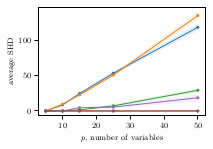

In [348]:
plt.figure(figsize = (3.0, 2.0))
plt.xlabel("$p$, number of variables")
#plt.ylabel("average empirical risk " + r"$R_{\mathrm{emp}}(W)$")
plt.ylabel("average SHD$")
def plot_results(method, metric, results, method_name, linestyle = '-'):
    # plot mean and standard error of DAG-OMP as a function of p.
    plt.plot(p_range, [np.mean(results[method][metric][10*i:10*i + 10]) for i in range(5)], marker = 'o', markersize = 2, linewidth = 1, label = method_name, linestyle = linestyle)
    plt.fill_between(p_range, [np.mean(results[method][metric][10*i:10*i + 10]) - sem(results[method][metric][10*i:10*i + 10])for i in range(5)], [np.mean(results[method][metric][10*i:10*i + 10]) + sem(results[method][metric][10*i:10*i + 10])for i in range(5)], alpha = 0.1)

metric = "shd"

plot_results("rw_2", metric, results, "Random Walk")
plot_results("mcmc_r", metric, results, "MH-R")
plot_results("mcmc_g", metric, results, "MH-G")

plot_results("notears", metric, results, "NO TEARS")
plot_results("dagomp", metric, results, "DAG-OMP")
plot_results("dagols", metric, results, "DAG-OLS-V")

# plot_results("daglasso", metric, results, "DAG-LASSO")
# plt.legend(ncol = 6, loc = 'upper left', bbox_to_anchor=(-0.08, 1.2), columnspacing = 0.75, handletextpad = 0.25)
# plt.savefig("empriskresultsacyclicT1000denseshd.pgf", bbox_inches = 'tight')

In [334]:
a_file = open(f"{datetime.now().strftime('%d_%m_%Y_%H_%M_%S')}datamatricesT1000dense.pkl", "wb")
pickle.dump(datasets, a_file)
a_file.close()

In [335]:
a_file = open(f"{datetime.now().strftime('%d_%m_%Y_%H_%M_%S')}dagomprwmcmcnotearsdenseT1000.pkl", "wb")
pickle.dump(results, a_file)
a_file.close()

In [135]:
print(results)

{'exh': {'mse': [], 'emse': [], 'shd': []}, 'rw_1': {'mse': [15.51930938321329, 14.924349291129303, 13.660942854655335], 'emse': [17.516740093308872, 15.401844761611144, 14.704537659885943], 'shd': [8, 5, 7]}, 'rw_2': {'mse': [13.999709388260959, 12.228860513658205, 11.009037499064128], 'emse': [16.00566941217162, 12.829642876442566, 11.46746177572549], 'shd': [8, 5, 3]}, 'mcmc_r': {'mse': [12.024503788670984, 13.31533144689828, 11.482735353102102], 'emse': [13.335378788807015, 13.635525214870079, 11.938330731617661], 'shd': [3, 6, 4]}, 'mcmc_t': {'mse': [13.613771055732878, 13.922145699454504, 13.337233489153268], 'emse': [18.70094473651455, 14.918398467202367, 14.102116452002623], 'shd': [8, 9, 6]}, 'mcmc_s': {'mse': [15.12822142217938, 12.884178708481915, 13.69909986030214], 'emse': [17.585350786235104, 14.172125584287423, 13.930770954147391], 'shd': [9, 5, 4]}, 'mcmc_g': {'mse': [15.401595274960952, 11.349025040383523, 10.744590216335688], 'emse': [16.325961093178222, 12.0083041498

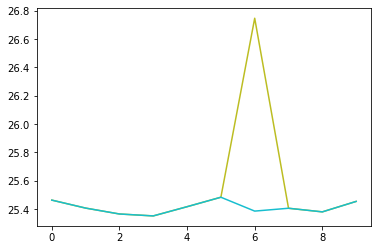

In [160]:
for method in results:
    for metric in results[method]:
        if metric == "emse" and method != "daglasso":
            plt.plot(results[method][metric])

In [115]:
import statsmodels.api as sm
import scipy.linalg as slin

def _h(W):
    """Evaluate value and gradient of acyclicity constraint."""
    W2 = W.copy()
    E = slin.expm(W2)  # (Zheng et al. 2018)
    h = np.trace(E) - p

    return h
    
def get_all_violating_edges(W, epsilon = 1e-16):
   
    h_val = _h(W)
    
    violators = set()
    
    for i in range(p):
        for j in range(p):
            if W[i][j] != 0:
                # remove Wij
                tmp = W[i][j]
                W[i][j] = 0
            
                # check h
                h_diff = h_val - _h(W)
            
                # check change
                if np.abs(h_diff) > epsilon:
                    violators.add((i, j))
            
                # add Wij back
                W[i][j] = tmp

    return violators

def B_V_LINGNAM_OLS(X, tol = 0.0):
    """OLS solution W, data X"""
       
    # get full OLS solution of W
    B = np.ones((p, p)) - np.identity(p)
    # print(B)
    W = con_OLS(X, B != 0)
    
    # print(np.round(W, 2))
    # get order of importance
    order_of_importance = []
    
    # scores
    scores = []
    
    # while we still do not have a DAG
    while not h.is_dag(W):       
        # get all violating edges
        violators = get_all_violating_edges(W)
        
        # find edge with smallest coefficient
        smallest_coef = np.min([np.abs(W[row][col]) for row, col in violators])
        row, col = np.where(np.abs(W) == smallest_coef)
        row, col = row[0], col[0]
    
        # set this edge to zero
        W[row][col] = 0
        
        # update column
        idx = np.nonzero(W[:, col])[0]
        W[idx, col] = (np.linalg.inv(X[:, idx].T @ X[:, idx]) @ X[:, idx].T @ X[:, col])
        
        # add edge and score to list
        # order_of_importance.append([row, col])
        # scores.append(h.MSE(W, X))
    
    # we have a dag, return this one for now
    W_return = W.copy()
    
    # Now that we have a DAG, we will greedily remove the least important edge
#     while len(np.nonzero(W)[0]) > 0:   
        
#         # set zero values to impossible value
#         W[W == 0] = 1e10
        
#         # get smallest nonzero coefficient in absolute value
#         row, col = np.argmin(np.abs(W)) // p, np.argmin(np.abs(W)) % p
        
#         # set this to zero
#         W[row][col] = 0
        
#         # revert the zero values back to zero
#         W[W == 1e10] = 0

#         edge = [row, col]
        
#         # update column
#         idx = np.nonzero(W[:, col])[0]
#         W[idx, col] = (np.linalg.inv(X[:-1, idx].T @ X[:-1, idx]) @ X[:-1, idx].T @ X[1:, col])
        
#         score = h.MSE(W, X)
        
#         if score < tol: 
#             break
            
#         order_of_importance.append(edge)
#         scores.append(h.MSE(W, X))
        
    # return the DAG W
    return W_return # , order_of_importance, scores

print(W)
W_B_V_LINGNAM_OLS = B_V_LINGNAM_OLS(X)
# print(f"OLS solution after iteratively removing the least important violators until we have a DAG:\n{np.round(W_B_V_LINGNAM_OLS, 2)}.")
# print(f"Importance of the removed edges, from least to most important:\n{edge_order}.")
print(W_B_V_LINGNAM_OLS)

[[ 0.         -1.87666118  1.02747896  1.63197154 -0.71325507]
 [ 0.          0.         -1.16274976 -1.15102099 -1.42665047]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.          0.         -0.63568902  0.          0.        ]
 [ 0.          0.          0.55892265 -1.32137923  0.        ]]
[[ 0.          0.          0.8593857   1.77231652 -0.79172154]
 [ 0.          0.         -1.13500276 -1.16966338 -1.4286161 ]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.          0.         -0.59596207  0.          0.        ]
 [ 0.          0.          0.70468068 -1.33204204  0.        ]]


In [178]:
W_m = W_B_V_LINGNAM_OLS.copy()

In [182]:
_, _, _, _, shd_1, mse, _ = h.score(X, W_m, W, printing = False)
# results[method]['mse'].append(mse)


# do thresholding to get shd
W_m[np.abs(W_m) <= 0.30] = 0

_, _, _, _, shd, _, _ = h.score(X, W_m, W, printing = False)
# results[method]['shd'].append(shd)

# do reestimated to get expected mean squared error
emse = expected_cost_var(W, con_OLS(X, W_m != 0))
# results[method]['emse'].append(emse)

if True:
    # print(method)
    print(f"SHD: {shd}, Empirial Risk: {round(mse, 3)}, True Risk: {round(emse, 3)}.")


SHD: 0, Empirial Risk: 24.691, True Risk: 25.408.
